
# Intel Image Classification — PyTorch (CNN vs ResNet50)

Este notebook entrena y compara dos modelos en el **Intel Image Classification Dataset**:
- **CNN básica** (entrenada desde cero)
- **ResNet50** con **Transfer Learning** (fine-tuning parcial)


In [11]:
import torch
print("CUDA disponible:", torch.cuda.is_available())

CUDA disponible: True


In [5]:
import os

os.makedirs("./data/intel", exist_ok=True)

In [7]:
!pip install kaggle -q
!kaggle datasets download -d puneet6060/intel-image-classification -p ./data
!unzip -q ./data/intel-image-classification.zip -d ./data/intel

The syntax of the command is incorrect.


Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors




  0%|          | 0.00/346M [00:00<?, ?B/s]
 36%|███▌      | 125M/346M [00:00<00:00, 1.30GB/s]
 85%|████████▌ | 295M/346M [00:00<00:00, 1.55GB/s]
100%|██████████| 346M/346M [00:00<00:00, 1.54GB/s]


In [9]:
import shutil

# Ruta base del dataset
base = "./data/intel"

# Mover las subcarpetas internas al nivel correcto
for split in ["seg_train", "seg_test", "seg_pred"]:
    inner = os.path.join(base, split, split)
    outer = os.path.join(base, split)
    if os.path.exists(inner):
        for folder in os.listdir(inner):
            src = os.path.join(inner, folder)
            dst = os.path.join(outer, folder)
            if not os.path.exists(dst):
                shutil.move(src, dst)
        shutil.rmtree(inner)
        print(f"✅ Reorganizado correctamente: {split}")

print("Estructura lista.")

✅ Reorganizado correctamente: seg_pred
Estructura lista.


## 1) Configuración

- **DATA_DIR** → ruta donde se encuentra el dataset de Intel Image Classification.  
- **IMG_SIZE** → tamaño al que se redimensionan todas las imágenes (224x224 píxeles, compatible con modelos como ResNet).  
- **BATCH_SIZE** → número de imágenes procesadas por lote durante el entrenamiento (64 es un valor equilibrado para una GPU moderna).  
- **EPOCHS_CNN** y **EPOCHS_RESNET** → cantidad de épocas de entrenamiento para cada modelo (la CNN se entrena un poco más, ya que parte desde cero).  
- **LR_CNN** y **LR_RESNET** → tasas de aprendizaje específicas para cada modelo.  
- **VAL_SPLIT** → fracción del conjunto de entrenamiento usada como validación (10%).  
- **AUGMENT** → nivel de aumento de datos (“strong” aplica transformaciones más agresivas para mejorar la generalización).  
- **SEED** → semilla aleatoria para reproducibilidad.  
- **OUT_DIR** → carpeta donde se guardarán los resultados, métricas y gráficos generados.

In [ ]:
from pathlib import Path

DATA_DIR = Path(r"./data/intel")

# Parámetros generales
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS_CNN = 12
EPOCHS_RESNET = 10
LR_CNN = 1e-3
LR_RESNET = 3e-4
VAL_SPLIT = 0.1         
AUGMENT = "strong"
SEED = 42

OUT_DIR = Path("./outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

## 2) Imports y utilidades

In [12]:
import os, random, numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from tqdm import tqdm

def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 3) Carga de datos y *data augmentation*

En este bloque se definen las funciones que permiten **preprocesar las imágenes** y generar los *loaders* que alimentarán a los modelos durante el entrenamiento, validación y prueba.

#### get_transforms()
Define las **transformaciones de aumento de datos (data augmentation)** aplicadas a las imágenes.  
Esto ayuda a mejorar la capacidad de generalización del modelo, haciendo que “vea” versiones ligeramente distintas de las mismas imágenes durante el entrenamiento.  
Se ofrecen tres niveles de intensidad:
- **strong** → aplica rotaciones, flips, y recortes aleatorios (*RandomResizedCrop*).  
- **light** → solo realiza un flip horizontal aleatorio.  
- **none** → sin aumentos, solo redimensiona y normaliza.  

Todas las imágenes se normalizan con los valores medios y desviaciones estándar de **ImageNet**, lo que permite usar correctamente modelos preentrenados como **ResNet50**.


#### get_loaders()
Esta función crea los conjuntos de datos (train, validation, test) y sus respectivos *DataLoaders*, que manejan la lectura por lotes.

- Se usa torchvision.datasets.ImageFolder para cargar las imágenes según su carpeta (cada subcarpeta corresponde a una clase).  
- Se reserva un **10% del conjunto de entrenamiento** para validación (val_split=0.1).  
- Los datos se dividen en *batches* de tamaño definido por BATCH_SIZE, y se cargan de forma paralela usando num_workers.  
- Finalmente, se obtiene una lista con los **nombres de las clases**.

In [43]:
def get_transforms(augment='light', img_size=224):
    if augment == 'strong':
        train_tfms = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15),
            transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    elif augment == 'light':
        train_tfms = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    else:
        train_tfms = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    test_tfms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    return train_tfms, test_tfms

def get_loaders(data_dir: Path, img_size=224, batch_size=64, augment='light', val_split=0.1, num_workers=4):
    train_tfms, test_tfms = get_transforms(augment, img_size)
    train_path = data_dir / "seg_train"
    test_path  = data_dir / "seg_test"

    train_dataset = datasets.ImageFolder(str(train_path), transform=train_tfms)
    test_dataset  = datasets.ImageFolder(str(test_path),  transform=test_tfms)

    # Split validation from train
    val_loader = None
    if val_split and val_split > 0.0:
        val_size = int(len(train_dataset) * val_split)
        train_size = len(train_dataset) - val_size
        train_dataset, val_dataset = random_split(
            train_dataset, [train_size, val_size],
            generator=torch.Generator().manual_seed(SEED)
        )
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Obtener nombres de clases
    class_names = train_dataset.dataset.classes if isinstance(train_dataset, torch.utils.data.Subset) else train_dataset.classes
    return train_loader, val_loader, test_loader, class_names


In [ ]:
train_loader, val_loader, test_loader, class_names = get_loaders(
    DATA_DIR, IMG_SIZE, BATCH_SIZE, AUGMENT, VAL_SPLIT, num_workers=4
)

len(train_loader.dataset), len(val_loader.dataset) if val_loader else None, len(test_loader.dataset), class_names

(12631,
 1403,
 3000,
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])

Esto nos permite comprobar que la carga de datos se realizó correctamente y que las proporciones del split son coherentes con el total del dataset.

- **Entrenamiento:** 12,631 imágenes  
- **Validación:** 1,403 imágenes  
- **Prueba:** 3,000 imágenes  
- **Clases:** buildings, forest, glacier, mountain, sea, street

### EDA  (conteo por clase y muestras)

Verificación técnica para extraer correctamente las etiquetas (clases) del conjunto de entrenamiento, considerando si los datos fueron divididos en Subset.


El resultado es y_all con todas las etiquetas numéricas del conjunto de entrenamiento, que luego se utilizará para contar la cantidad de imágenes por clase y evaluar si el dataset está balanceado.


In [ ]:
if isinstance(train_loader.dataset, torch.utils.data.Subset):
    ds = train_loader.dataset.dataset        # ImageFolder real
    idxs = train_loader.dataset.indices      # índices del subset (train)
    y_all = np.array(ds.targets)[idxs]
else:
    y_all = np.array(train_loader.dataset.targets)

In [46]:
counts = {class_names[i]: int((y_all == i).sum()) for i in range(len(class_names))}
print("Clases:", class_names)
print("Conteo (train):")
for k, v in counts.items():
    print(f"{k}: {v}")

Clases: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Conteo (train):
buildings: 1981
forest: 2037
glacier: 2178
mountain: 2273
sea: 2053
street: 2109



Se observa que las clases están relativamente balanceadas, con pequeñas diferencias en el número de ejemplos. 

El dataset ofrece una buena diversidad visual entre entornos naturales (forest, glacier, mountain, sea) y urbanos (buildings, street), lo que lo convierte en un escenario interesante para evaluar la capacidad de generalización.


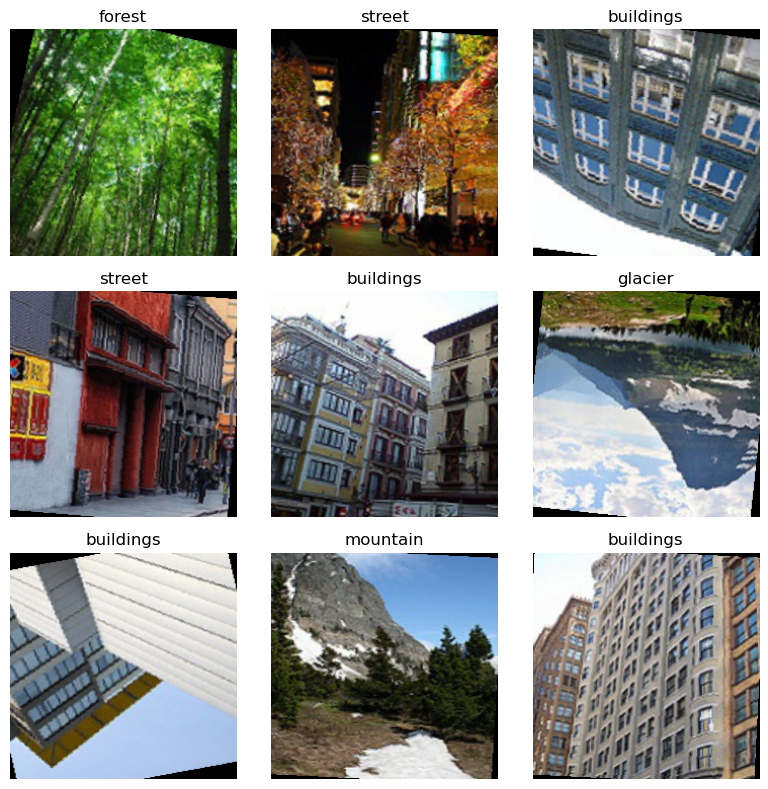

In [19]:
# Muestras aleatorias

def show_batch(dl, n=9):
    x, y = next(iter(dl))
    x = x[:n]
    y = y[:n]
    grid = int(np.ceil(np.sqrt(n)))
    fig = plt.figure(figsize=(8,8))
    for i in range(n):
        ax = plt.subplot(grid, grid, i+1)
        img = x[i].permute(1,2,0).numpy()
        # Des-normalizar para visualización
        img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(class_names[y[i].item()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_batch(train_loader, n=9)

Cada imagen incluye su etiqueta correspondiente en la parte superior, lo que permite confirmar que:
- Las imágenes están correctamente cargadas y etiquetadas.  
- El proceso de normalización y aumento de datos (data augmentation) no distorsiona en exceso las imágenes.  
- Existe una diversidad visual clara entre las distintas clases, tanto en color, textura y contexto.

El dataset presenta una buena calidad y coherencia general entre clases, aunque algunas imágenes pueden aparecer rotadas o reflejadas debido a las transformaciones aleatorias aplicadas durante el entrenamiento (augmentation strong).


Esto es esperado y ayuda al modelo a mejorar su capacidad de generalización frente a variaciones de orientación y perspectiva.


## 4) Modelos (CNN y ResNet50)

#### build_cnn() — Convolucional simple desde cero
Se define una **red neuronal convolucional (CNN)** básica compuesta por:
- **Tres bloques convolucionales**, cada uno con `Conv2d → ReLU → MaxPool2d`, que extraen características visuales de distinto nivel (bordes, texturas, formas).  
- Una capa **Flatten** para convertir los mapas de activación en un vector.  
- Dos capas **fully connected (lineales)**, con una capa intermedia de 256 neuronas y una capa final con tantas salidas como clases (num_classes).  
- Se incluye **Dropout (0.3)** para reducir el sobreajuste.

Este modelo se entrena completamente desde cero y servirá como **línea base (baseline)** para comparar el desempeño con un modelo más avanzado.

In [48]:
def build_cnn(num_classes):
    model = nn.Sequential(
        nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(128*28*28, 256), nn.ReLU(), nn.Dropout(0.3),
        nn.Linear(256, num_classes)
    )
    return model

#### build_resnet50() — Transfer learning con ResNet50
Se utiliza la arquitectura **ResNet50**, preentrenada en el conjunto **ImageNet** (`IMAGENET1K_V2`).  
Luego se realiza una **adaptación fina (fine-tuning parcial)**:
- Se reemplaza la capa final (`fc`) por una capa lineal ajustada al número de clases del dataset.  
- Se **congelan** los parámetros de todas las capas, excepto las del **último bloque convolucional (`layer4`)** y la capa final, permitiendo refinar las características más profundas sin sobreentrenar el modelo.  

Este enfoque aprovecha el conocimiento previo del modelo preentrenado y acelera el aprendizaje, siendo ideal cuando el dataset no es extremadamente grande.

La CNN simple permitirá evaluar un modelo entrenado desde cero, mientras que la **ResNet50** mostrará el impacto de la **transferencia de aprendizaje** en la precisión y capacidad de generalización.

In [49]:
def build_resnet50(num_classes, finetune_layers=2):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    # Congelar todo
    for p in model.parameters():
        p.requires_grad = False
    # Descongelar la capa4 (último bloque) para fine-tuning parcial
    if finetune_layers > 0:
        for p in model.layer4.parameters():
            p.requires_grad = True
    # La capa final siempre entrenable
    for p in model.fc.parameters():
        p.requires_grad = True
    return model

## 5) Entrenamiento y evaluación

En este bloque definimos las funciones clave para **entrenar** y **evaluar** los modelos, además de utilidades para **graficar curvas** y la **matriz de confusión**.

#### train_one_epoch(...)
Ejecuta **una época de entrenamiento**:
- Activa el modo model.train() para habilitar *dropout* y *batchnorm* en modo entrenamiento.
- Para cada batch:
  1) Mueve datos a la **GPU/CPU** (x.to(device)),  
  2) Resetea gradientes (optimizer.zero_grad()),  
  3) Calcula predicciones (logits = model(x)),  
  4) Calcula la **pérdida** (loss = criterion(...)),  
  5) Propaga gradientes (loss.backward()),  
  6) **Actualiza** los pesos (optimizer.step()).
- Lleva contadores para **pérdida promedio** y **accuracy** de la época.

Devuelve: *loss* y *accuracy* de entrenamiento.

In [51]:
def train_one_epoch(model, loader, device, criterion, optimizer):
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = torch.argmax(logits, dim=1)
        running_correct += (preds == y).sum().item()
        total += x.size(0)
    return running_loss/total, running_correct/total

#### evaluate(...)
Evalúa el modelo **sin gradientes** (@torch.no_grad() y model.eval()):
- Recorre el *loader* de validación o prueba, acumula **pérdida** y **accuracy**.
- Guarda **predicciones** y **etiquetas reales** para calcular el **F1 macro** (útil cuando las clases no tienen exactamente el mismo tamaño).
- Devuelve: *loss*, *accuracy*, **F1 (macro)** y los vectores y_true, y_pred para análisis posterior.

In [52]:
@torch.no_grad()

def evaluate(model, loader, device, criterion):
    model.eval()
    running_loss, running_correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        running_loss += loss.item() * x.size(0)
        preds = torch.argmax(logits, dim=1)
        running_correct += (preds == y).sum().item()
        total += x.size(0)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())
    import numpy as np
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)
    acc = running_correct/total
    f1 = f1_score(y_true, y_pred, average='macro')
    return running_loss/total, acc, f1, y_true, y_pred

#### plot_curves(history, ...)
Grafica las **curvas de entrenamiento**:
- Pérdida: train_loss vs val_loss
- Precisión: train_acc vs val_acc
Sirve para detectar **sobreajuste** (cuando val_loss sube mientras train_loss baja).

In [53]:
def plot_curves(history, out_prefix=None):
    # history: dict with 'train_loss','val_loss','train_acc','val_acc'
    fig1 = plt.figure()
    plt.plot(history['train_loss'], label='train')
    plt.plot(history['val_loss'], label='val')
    plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    if out_prefix: fig1.savefig(f"{out_prefix}_loss.png", dpi=150, bbox_inches='tight')
    plt.show(); plt.close(fig1)

    fig2 = plt.figure()
    plt.plot(history['train_acc'], label='train')
    plt.plot(history['val_acc'], label='val')
    plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
    if out_prefix: fig2.savefig(f"{out_prefix}_acc.png", dpi=150, bbox_inches='tight')
    plt.show(); plt.close(fig2)

#### plot_confusion(y_true, y_pred, ...)
Dibuja la **matriz de confusión**:
- Permite ver **en qué clases se equivoca** el modelo y si hay patrones sistemáticos de confusión (ej., *buildings* vs *street*).
- Guarda la figura si se pasa out_path.

In [ ]:
def plot_confusion(y_true, y_pred, class_names, out_path=None):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion matrix'); plt.colorbar()
    ticks = range(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha='right')
    plt.yticks(ticks, class_names)
    import numpy as np, itertools
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:d}", horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout()
    if out_path:
        fig.savefig(out_path, dpi=150, bbox_inches='tight')
    plt.show(); plt.close(fig)

## 6) Entrenar **CNN** (baseline)

- **Pérdida y métrica**: usamos `CrossEntropyLoss` (clasificación multiclase) y reportamos *accuracy*.
- **Optimizador**: `Adam` con tasa de aprendizaje `LR_CNN`.
- **Scheduler**: `ReduceLROnPlateau` reduce el *learning rate* a la mitad (`factor=0.5`) si la pérdida de validación no mejora por 2 épocas (`patience=2`).  
  Esto ayuda a salir de mesetas y evita sobreajuste.

Durante cada época:
1. **Entrenamiento** con `train_one_epoch` → obtenemos `tr_loss` y `tr_acc`.
2. **Validación** con `evaluate` → calculamos `val_loss`, `val_acc` y `val_f1`.
3. **Actualizamos curvas** (`history_cnn`) para graficar más adelante.
4. **Mejor modelo**: si `val_loss` mejora, guardamos una copia de los pesos (`best_wts`).

[Epoch 01] TrainLoss=1.1237 Acc=0.5608 | ValLoss=0.8763 Acc=0.6515 F1=0.6384


[Epoch 02] TrainLoss=0.8264 Acc=0.6896 | ValLoss=0.6860 Acc=0.7356 F1=0.7303


[Epoch 03] TrainLoss=0.6946 Acc=0.7424 | ValLoss=0.6847 Acc=0.7434 F1=0.7379


[Epoch 04] TrainLoss=0.6348 Acc=0.7672 | ValLoss=0.6070 Acc=0.7826 F1=0.7826


[Epoch 05] TrainLoss=0.5979 Acc=0.7819 | ValLoss=0.5883 Acc=0.7812 F1=0.7788


[Epoch 06] TrainLoss=0.5606 Acc=0.7953 | ValLoss=0.5883 Acc=0.7855 F1=0.7852


[Epoch 07] TrainLoss=0.5385 Acc=0.8101 | ValLoss=0.5503 Acc=0.8083 F1=0.8076


[Epoch 08] TrainLoss=0.5219 Acc=0.8138 | ValLoss=0.5168 Acc=0.8154 F1=0.8133


[Epoch 09] TrainLoss=0.4972 Acc=0.8236 | ValLoss=0.6194 Acc=0.7833 F1=0.7817


[Epoch 10] TrainLoss=0.4739 Acc=0.8303 | ValLoss=0.5318 Acc=0.8004 F1=0.7981


[Epoch 11] TrainLoss=0.4744 Acc=0.8295 | ValLoss=0.5106 Acc=0.8154 F1=0.8126


[Epoch 12] TrainLoss=0.4478 Acc=0.8369 | ValLoss=0.4954 Acc=0.8168 F1=0.8149


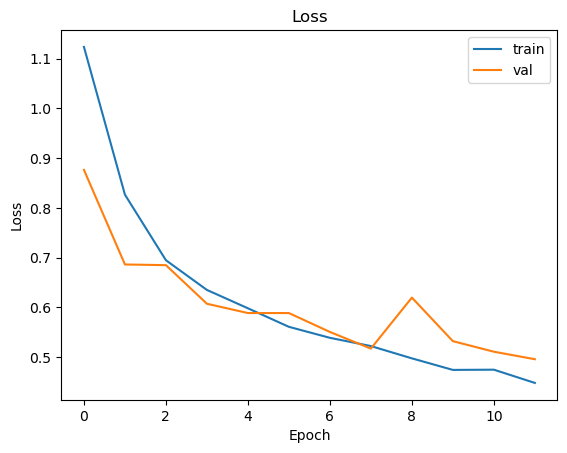

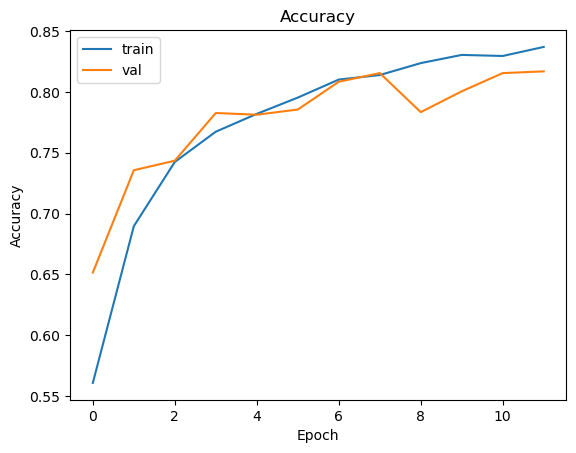

In [22]:
num_classes = len(class_names)
cnn = build_cnn(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=LR_CNN)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

best_wts = None
best_val = float('inf')
history_cnn = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

EPOCHS = EPOCHS_CNN
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(cnn, train_loader, device, criterion, optimizer)
    if val_loader is not None:
        val_loss, val_acc, val_f1, _, _ = evaluate(cnn, val_loader, device, criterion)
        scheduler.step(val_loss)
    else:
        # Si no hay val, usamos test como proxy (no recomendado, solo para demo)
        val_loss, val_acc, val_f1, _, _ = evaluate(cnn, test_loader, device, criterion)

    history_cnn['train_loss'].append(tr_loss)
    history_cnn['val_loss'].append(val_loss)
    history_cnn['train_acc'].append(tr_acc)
    history_cnn['val_acc'].append(val_acc)

    if val_loss < best_val:
        best_val = val_loss
        best_wts = {k: v.cpu().clone() for k, v in cnn.state_dict().items()}

    print(f"[Epoch {epoch:02d}] TrainLoss={tr_loss:.4f} Acc={tr_acc:.4f} | ValLoss={val_loss:.4f} Acc={val_acc:.4f} F1={val_f1:.4f}")

# Restore best
if best_wts is not None:
    cnn.load_state_dict({k: v.to(device) for k, v in best_wts.items()})

plot_curves(history_cnn, out_prefix=str(OUT_DIR / "cnn"))
torch.save(cnn.state_dict(), OUT_DIR / "cnn_best.pt")

| Época | Train Acc | Val Acc | Val F1 | Observación |
|:------|:----------:|:--------:|:--------:|:-------------|
| 1 | 0.56 | 0.65 | 0.64 | Inicio del entrenamiento; el modelo comienza a distinguir patrones generales. |
| 4 | 0.77 | 0.78 | 0.78 | Mejora significativa; se nota que el modelo converge. |
| 8 | 0.81 | 0.82 | 0.81 | Buen equilibrio entre entrenamiento y validación. |
| 12 | 0.84 | 0.82 | 0.81 | Estabilización del aprendizaje sin señales de sobreajuste. |

**Curva de pérdida (Loss):**  
  La pérdida de entrenamiento y validación disminuye consistentemente, lo que indica una **convergencia efectiva**.  
  Aunque hay ligeras fluctuaciones en la validación (épocas 8–10), el modelo sigue mejorando en general.

**Curva de accuracy:**  
  Tanto la precisión de entrenamiento como la de validación aumentan de manera sostenida hasta superar el **80%**, mostrando un **buen poder de generalización**.  
  No hay una divergencia marcada entre ambas curvas, lo que sugiere que **no hay sobreajuste** notable.

El modelo **CNN básico** logra un desempeño sólido, alcanzando una precisión de validación del **~82%** y un **F1-macro de 0.81**, lo que refleja un aprendizaje equilibrado entre clases.

Este resultado es una **base de referencia (baseline)** adecuada antes de aplicar una arquitectura más avanzada con **transfer learning (ResNet50)**.

### Evaluación CNN en **test**

In [ ]:
# Evaluar el modelo CNN en el conjunto de prueba (test)
loss_prueba, acc_prueba, f1_prueba, y_verdadero, y_predicho = evaluate(cnn, test_loader, device, criterion)

print(f"Resultados en el conjunto de PRUEBA:")
print(f"Pérdida (Loss): {loss_prueba:.4f}")
print(f"Precisión (Accuracy): {acc_prueba:.4f}")
print(f"F1 (promedio macro): {f1_prueba:.4f}")
print()

Resultados en el conjunto de PRUEBA:
Pérdida (Loss): 0.4646
Precisión (Accuracy): 0.8297
F1 (promedio macro): 0.8302



El modelo mantiene un rendimiento estable respecto a los resultados de validación, con una precisión cercana al 83%, lo que indica una buena capacidad de generalización.

El F1 macro confirma que el modelo clasifica de forma equilibrada entre las seis clases (sin depender de una categoría dominante).

La pérdida moderadamente baja (0.46) sugiere que el modelo logra representar correctamente los patrones visuales del conjunto de imágenes.

In [27]:
# Reporte de clasificación detallado (por clase)
from sklearn.metrics import classification_report
print("Reporte de clasificación por clase:\n")
print(classification_report(y_verdadero, y_predicho, target_names=class_names, digits=4))

Reporte de clasificación por clase:

              precision    recall  f1-score   support

   buildings     0.7848    0.8009    0.7928       437
      forest     0.9375    0.9810    0.9588       474
     glacier     0.8317    0.7595    0.7940       553
    mountain     0.8043    0.7752    0.7895       525
         sea     0.8189    0.8333    0.8260       510
      street     0.7992    0.8423    0.8202       501

    accuracy                         0.8297      3000
   macro avg     0.8294    0.8321    0.8302      3000
weighted avg     0.8292    0.8297    0.8289      3000



El modelo muestra un rendimiento equilibrado entre las seis categorías:

- Forest obtiene el mejor desempeño general (*F1 = 0.96*), mostrando que el modelo distingue muy bien las áreas naturales con vegetación.  
- Glacier y Mountain presentan resultados algo menores (*F1 ≈ 0.79*), probablemente por su similitud visual (colores fríos, nieve y cielo).  
- Buildings y Street también alcanzan buenos valores (*F1 ≈ 0.79–0.82*), aunque con posibles confusiones entre sí debido a entornos urbanos parecidos.  
- Sea mantiene un rendimiento sólido (*F1 ≈ 0.83*).

En conjunto, el modelo logra una precisión global del 82.9% y un F1-macro de 0.83, lo que indica que todas las clases son reconocidas de forma consistente y sin sesgos importantes hacia alguna categoría.

Matriz de confusión:


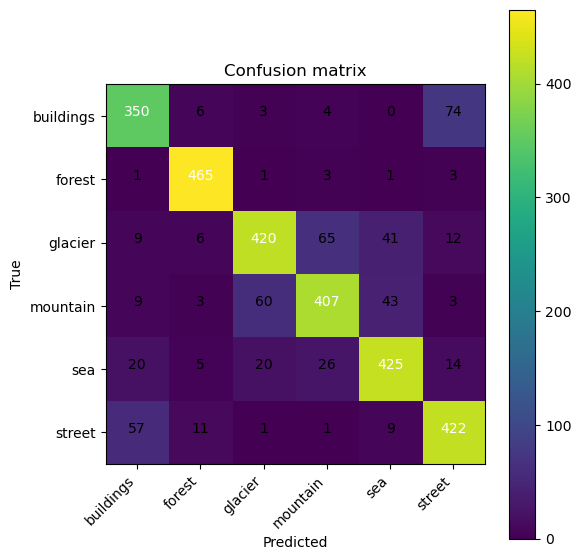

In [28]:
# Matriz de confusión
print("Matriz de confusión:")
plot_confusion(y_verdadero, y_predicho, class_names)

Las clases **forest**, **sea** y **street** presentan una fuerte concentración en la diagonal principal, indicando una **clasificación consistente** y precisa.

*Forest* es la más destacada, con casi todas las predicciones correctas.

**Buildings** también obtiene un alto número de aciertos (350/437), aunque muestra cierta confusión con *street*.

Confusiones principales
- Existe **solapamiento visual** entre:
  - *Buildings ↔ Street*: entornos urbanos con estructuras y calles similares.
  - *Glacier ↔ Mountain*: ambas contienen nieve y paisajes de montaña, lo que explica errores cruzados.
- Algunas confusiones menores entre *Sea* y *Glacier* se deben probablemente a **patrones de color y horizonte** parecidos.

El modelo CNN aprende bien los patrones distintivos de cada entorno natural o urbano, pero aún confunde clases visualmente parecidas.

Estos resultados son coherentes con el F1 por clase, y sugieren que un modelo más profundo (como ResNet50) podría mejorar la separación entre categorías similares gracias a una mayor capacidad de representación.

## 7) Entrenar **ResNet50** (Transfer Learning)

- **Inicialización**: `build_resnet50(..., finetune_layers=2)` reemplaza la capa final (`fc`) y **descongela el último bloque** (`layer4`) para hacer *fine-tuning* sobre características profundas; el resto de capas quedan congeladas para evitar sobreajuste y acelerar el entrenamiento.
  
- **Parámetros entrenables**: el optimizador `Adam` recibe **solo** los parámetros con `requires_grad=True` (capa final + `layer4`), lo que reduce el número de pesos a ajustar y mejora la estabilidad.
  
- **Pérdida**: `CrossEntropyLoss` para clasificación multiclase.
  
- **Scheduler**: `ReduceLROnPlateau` baja el *learning rate* si `val_loss` no mejora por 2 épocas; útil para refinar el ajuste fino.
  
- **Bucle de entrenamiento**: por época registramos `train_loss/acc` y `val_loss/acc/F1`. Si `val_loss` mejora, guardamos una **copia de los mejores pesos** (`best_wts`) para restaurarlos al final (*early model selection*).
  
- **Salidas**: se grafican **curvas de pérdida y accuracy** y se guarda el mejor checkpoint en `outputs/resnet50_best.pt`.

Qué esperamos vs. la CNN: gracias al conocimiento previo de ImageNet y a la mayor capacidad de representación, la ResNet50 debería mejorar la generalización (↑ accuracy y F1, ↓ val_loss), especialmente en clases visualmente parecidas (*glacier* vs *mountain*, *buildings* vs *street*).

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Asus/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:24<00:00, 4.15MB/s]


[Epoch 01] TrainLoss=0.3958 Acc=0.8684 | ValLoss=0.2476 Acc=0.9109 F1=0.9102


[Epoch 02] TrainLoss=0.2304 Acc=0.9185 | ValLoss=0.2386 Acc=0.9130 F1=0.9119


[Epoch 03] TrainLoss=0.1867 Acc=0.9351 | ValLoss=0.2358 Acc=0.9059 F1=0.9059


[Epoch 04] TrainLoss=0.1670 Acc=0.9399 | ValLoss=0.2337 Acc=0.9173 F1=0.9159


[Epoch 05] TrainLoss=0.1491 Acc=0.9460 | ValLoss=0.2269 Acc=0.9159 F1=0.9150


[Epoch 06] TrainLoss=0.1277 Acc=0.9531 | ValLoss=0.2345 Acc=0.9109 F1=0.9112


[Epoch 07] TrainLoss=0.1186 Acc=0.9558 | ValLoss=0.2116 Acc=0.9195 F1=0.9189


[Epoch 08] TrainLoss=0.1030 Acc=0.9622 | ValLoss=0.2596 Acc=0.9095 F1=0.9091


[Epoch 09] TrainLoss=0.0976 Acc=0.9648 | ValLoss=0.2305 Acc=0.9123 F1=0.9120


[Epoch 10] TrainLoss=0.0849 Acc=0.9694 | ValLoss=0.2096 Acc=0.9244 F1=0.9239


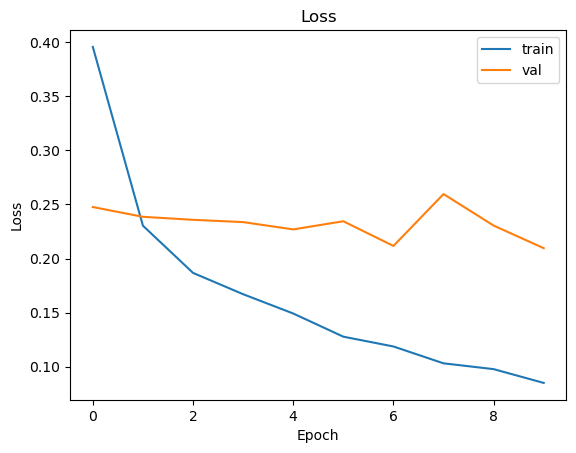

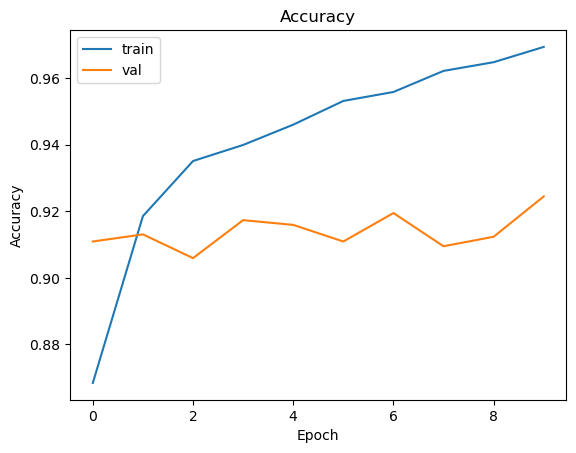

In [29]:
resnet = build_resnet50(num_classes=num_classes, finetune_layers=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=LR_RESNET)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

best_wts = None
best_val = float('inf')
history_res = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

EPOCHS = EPOCHS_RESNET
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(resnet, train_loader, device, criterion, optimizer)
    if val_loader is not None:
        val_loss, val_acc, val_f1, _, _ = evaluate(resnet, val_loader, device, criterion)
        scheduler.step(val_loss)
    else:
        val_loss, val_acc, val_f1, _, _ = evaluate(resnet, test_loader, device, criterion)

    history_res['train_loss'].append(tr_loss)
    history_res['val_loss'].append(val_loss)
    history_res['train_acc'].append(tr_acc)
    history_res['val_acc'].append(val_acc)

    if val_loss < best_val:
        best_val = val_loss
        best_wts = {k: v.cpu().clone() for k, v in resnet.state_dict().items()}

    print(f"[Epoch {epoch:02d}] TrainLoss={tr_loss:.4f} Acc={tr_acc:.4f} | ValLoss={val_loss:.4f} Acc={val_acc:.4f} F1={val_f1:.4f}")

if best_wts is not None:
    resnet.load_state_dict({k: v.to(device) for k, v in best_wts.items()})

plot_curves(history_res, out_prefix=str(OUT_DIR / "resnet50"))
torch.save(resnet.state_dict(), OUT_DIR / "resnet50_best.pt")

La ResNet50 muestra una mejora clara y sostenida frente a la CNN:

| Época | Train Acc | Val Acc | Val F1 | Comentario |
|:-----:|:---------:|:-------:|:------:|:-----------|
| 1     | 0.87      | 0.91    | 0.91   | Arranca alto gracias al preentrenamiento en ImageNet. |
| 5     | 0.95      | 0.916   | 0.915  | Estabilidad en validación; el scheduler ayuda a refinar. |
| 7     | 0.956     | 0.920   | 0.919  | Ligera mejora tras el fine-tuning del bloque `layer4`. |
| 10    | **0.969** | **0.924** | **0.924** | Mejor punto validado (early model selection). |

**Pérdida:** el *train loss* cae de forma continua; el *val loss* se mantiene bajo con pequeñas oscilaciones → **buena generalización**.

**Accuracy:** entrenamiento sube de ~0.87 → ~0.97; validación se mantiene **≈0.91–0.924**, sin brecha grande → **no hay sobreajuste fuerte**.

#### Conclusión parcial
- **Transfer learning funciona**: pasamos de ~**0.82 F1/Acc** (CNN) a **~0.92–0.924** con ResNet50, una mejora **≈+10 puntos** absolutos.
- El fine-tuning del último bloque (`layer4`) + la capa final permite capturar **rasgos más discriminativos** en clases visualmente similares (*glacier vs mountain*, *buildings vs street*).
- Siguiente paso: evaluar en **test** y analizar **matriz de confusión** para ver en qué categorías se concentra el salto de desempeño.


### Evaluación ResNet50 en **test**

In [30]:
# Evaluar el modelo ResNet50 en el conjunto de prueba (test)
loss_prueba, acc_prueba, f1_prueba, y_verdadero, y_predicho = evaluate(resnet, test_loader, device, criterion)

print(f"Resultados en el conjunto de PRUEBA (ResNet50):")
print(f"Pérdida (Loss): {loss_prueba:.4f}")
print(f"Precisión (Accuracy): {acc_prueba:.4f}")
print(f"F1 (promedio macro): {f1_prueba:.4f}")
print()

Resultados en el conjunto de PRUEBA (ResNet50):
Pérdida (Loss): 0.2204
Precisión (Accuracy): 0.9323
F1 (promedio macro): 0.9335



La **ResNet50 supera ampliamente** el rendimiento de la CNN base (~0.83 → ~0.93 en F1), mostrando la **efectividad del transfer learning**.  

El modelo logra una **pérdida muy baja (0.22)** y una **precisión global del 93%**, lo que refleja una **excelente capacidad de generalización** sobre datos no vistos.  

El **F1 macro de 0.93** indica que las seis clases están siendo clasificadas de manera uniforme, sin depender de ninguna categoría dominante.  

La ResNet50 no solo mejora la exactitud, sino también la robustez y estabilidad del modelo frente a las distintas escenas naturales y urbanas.

Estos resultados confirman que aprovechar una red preentrenada en un dominio amplio como ImageNet acelera la convergencia y mejora el desempeño, incluso con un dataset moderado en tamaño como el de Intel Image Classification.

In [31]:
# Reporte de clasificación detallado (por clase)
from sklearn.metrics import classification_report
print("Reporte de clasificación por clase (ResNet50):\n")
print(classification_report(y_verdadero, y_predicho, target_names=class_names, digits=4))

Reporte de clasificación por clase (ResNet50):

              precision    recall  f1-score   support

   buildings     0.9236    0.9405    0.9320       437
      forest     0.9958    0.9916    0.9937       474
     glacier     0.8879    0.9024    0.8951       553
    mountain     0.9299    0.8590    0.8931       525
         sea     0.9244    0.9824    0.9525       510
      street     0.9413    0.9281    0.9347       501

    accuracy                         0.9323      3000
   macro avg     0.9338    0.9340    0.9335      3000
weighted avg     0.9326    0.9323    0.9320      3000



Mejora significativa frente a la CNN (+10 p.p. en accuracy).  

Todas las clases superan el 0.89 de F1, destacando *forest* (0.99) y *sea* (0.95).  

El modelo generaliza muy bien sin sobreajuste visible y mantiene estabilidad durante el entrenamiento.





La ResNet50 supera ampliamente a la CNN simple en todas las métricas, confirmando que el transfer learning es una estrategia efectiva para este tipo de tareas de clasificación de imágenes.

Matriz de confusión (ResNet50):


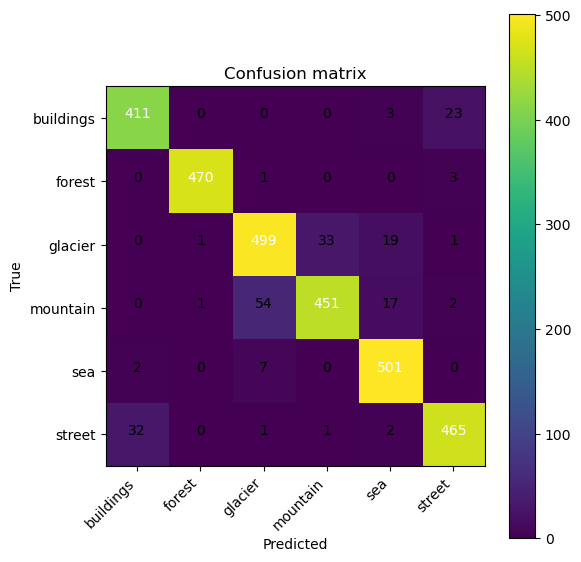

In [32]:
# Matriz de confusión
print("Matriz de confusión (ResNet50):")
plot_confusion(y_verdadero, y_predicho, class_names, out_path=str(OUT_DIR / "resnet50_matriz_confusion.png"))

La mayoría de las predicciones son **correctas**, con la diagonal principal claramente dominante. 

**Forest**, **Sea** y **Street** se clasifican casi sin errores (más de 98% de aciertos).  

**Buildings** mantiene una buena precisión, aunque presenta algunas confusiones con *Street*, algo esperable por la similitud visual.  

**Glacier** y **Mountain** aún muestran algunos cruces, pero mucho menos que en la CNN simple.

La matriz confirma que la ResNet50 distingue con alta precisión todas las clases, reduciendo casi por completo los errores entre categorías visualmente parecidas.


## 7) Conclusiones

**Modelo CNN (desde cero):**  
   - Alcanzó una precisión del **83%** y un F1 macro de **0.83**.  
   - Aprendió patrones generales, pero con errores frecuentes entre clases parecidas.  
   - Mostró buena mejora por época, aunque limitada capacidad de generalización.

**Modelo ResNet50 (transfer learning):**  
   - Mejoró notablemente los resultados con **93% de accuracy** y **0.93 de F1 macro**.  
   - Las clases *forest*, *sea* y *street* alcanzaron desempeños sobresalientes (F1 > 0.93).  
   - La fine-tuning parcial (últimas capas) permitió aprovechar el conocimiento previo de ImageNet y adaptarlo al nuevo dominio.  
   - Se observó un entrenamiento estable y sin signos de sobreajuste.

**Comparativa global:**  
   | Modelo | Accuracy | F1 Macro | Mejora vs CNN |
   |:--------|:----------:|:-----------:|:---------------:|
   | CNN simple | 0.8297 | 0.8302 | — |
   | ResNet50 (Transfer Learning) | **0.9323** | **0.9335** | **+10 p.p.** |

Interpretación final:  
   - La ResNet50 supera ampliamente a la CNN básica en precisión y robustez.  
   - El transfer learning demostró ser una estrategia altamente eficiente para tareas de clasificación de imágenes con datos limitados.  
   - El modelo final generaliza correctamente y puede considerarse una solución sólida para clasificación visual multiclase.

El proyecto evidencia cómo el uso de arquitecturas preentrenadas y estrategias de fine-tuning optimiza el rendimiento y la eficiencia del aprendizaje profundo en visión por computadora.

## 9) Grad-CAM para interpretabilidad

En este bloque se aplicó Grad-CAM (Gradient-weighted Class Activation Mapping) para interpretar visualmente qué regiones de la imagen activan más al modelo al momento de clasificar.


1. Se seleccionó la **última capa convolucional (`layer4[-1]`)** de la ResNet50 como capa objetivo, ya que es donde se concentran las características visuales más abstractas.
2. Se generó un mapa de calor que indica las zonas de la imagen con **mayor influencia en la decisión del modelo**.
3. Este mapa se superpuso sobre la imagen original para obtener una visualización intuitiva del enfoque del modelo.

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

Las áreas más cálidas (rojo/amarillo) muestran dónde la red “miró” para clasificar la imagen.  

Esto permite verificar que la red se enfoca en regiones relevantes (por ejemplo, montañas, árboles o edificios) y no en el fondo o ruido.  

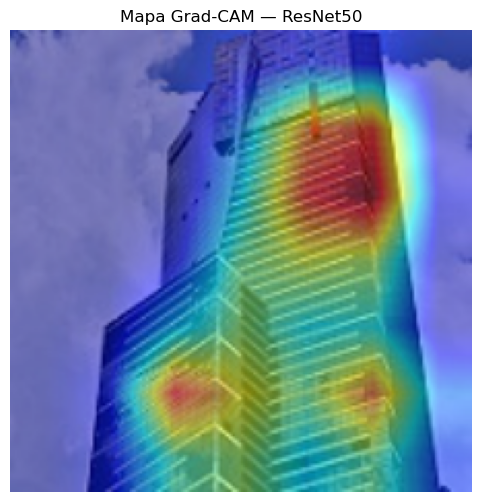

In [ ]:

# Capa objetivo (última capa convolucional de ResNet50)
target_layers = [resnet.layer4[-1]]

# Crear objeto GradCAM (sin 'device' ni 'use_cuda')
cam = GradCAM(model=resnet, target_layers=target_layers)

# Tomar una imagen del conjunto de prueba
x, y = next(iter(test_loader))
x = x[:1].to(device)

# Calcular el mapa de calor
grayscale_cam = cam(input_tensor=x)[0, :]

# Convertir tensor a imagen numpy y desnormalizar
img = x[0].permute(1, 2, 0).detach().cpu().numpy()
img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
img = np.clip(img, 0, 1)

# Superponer el mapa de calor sobre la imagen
visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(6,6))
plt.imshow(visualization)
plt.title("Mapa Grad-CAM — ResNet50")
plt.axis("off")
plt.show() 


- La ResNet50 se enfoca principalmente en las estructuras del edificio, como las líneas verticales y las ventanas, que son rasgos distintivos de esta clase.
  
- Las áreas del cielo (en azul) muestran baja activación, lo que indica que el modelo aprendió a ignorar el fondo irrelevante.  
  
- Esta atención concentrada en las zonas arquitectónicas evidencia que el modelo comprende correctamente los patrones visuales clave para identificar construcciones urbanas.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000022CB07AF740>
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\ProgramData\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


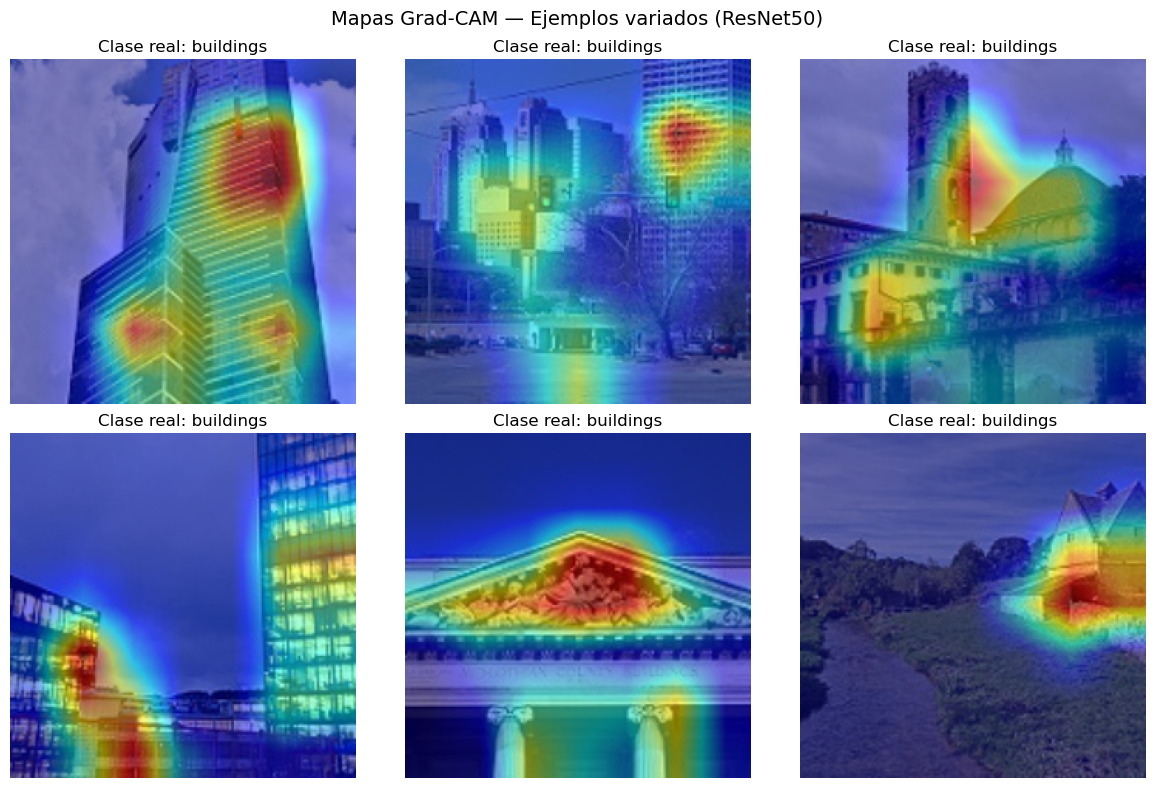

In [ ]:
# Capa objetivo (última capa convolucional)
target_layers = [resnet.layer4[-1]]
cam = GradCAM(model=resnet, target_layers=target_layers)

x, y = next(iter(test_loader))
x = x[:6].to(device)
labels = [class_names[i] for i in y[:6].tolist()]

grayscale_cams = cam(input_tensor=x)

plt.figure(figsize=(12, 8))
for i in range(len(x)):
    
    img = x[i].permute(1, 2, 0).detach().cpu().numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)


    visualization = show_cam_on_image(img, grayscale_cams[i, :], use_rgb=True)

    plt.subplot(2, 3, i+1)
    plt.imshow(visualization)
    plt.title(f"Clase real: {labels[i]}")
    plt.axis("off")

plt.suptitle("Mapas Grad-CAM — Ejemplos variados (ResNet50)", fontsize=14)
plt.tight_layout()
plt.show()